In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime, date


from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

from datetime import datetime, date
import csv

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.figsize'] = 4.8,3.2
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.fancybox'] = True

/Users/Jay/miniconda3/envs/sf-walk-safety/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Read data

In [2]:
dataset = 'thefts'
#dataset = 'robberies'

if dataset == 'thefts':
    fulldf = pd.read_pickle('../data/theft-street.p')
    lowercase = 'thefts'
    uppercase = 'Thefts'
elif dataset == 'robberies':
    fulldf = pd.read_pickle('../data/robbery-street.p')
    lowercase = 'robberies'
    uppercase = 'Robberies'

In [3]:
# Add month and year columns
fulldf['month'] = fulldf.date.apply(lambda x: x.month)
fulldf['year'] = fulldf.date.apply(lambda x: x.year)

# Read weather data
weatherfull = pd.read_pickle(r"../data/noaa-weather-downtown-sf.p")


# Convert celsius to fahrenheit
def celsius2fahrenheit(T):
    return T * 1.8 + 32
weatherfull['TMAX'] = weatherfull['TMAX'].apply(celsius2fahrenheit)
weatherfull['TMIN'] = weatherfull['TMIN'].apply(celsius2fahrenheit)

# Join with weather
print 'merge with weather'
print 'before merge', fulldf.shape
fulldf = fulldf.merge(weatherfull,how="inner",left_on="date",right_on="DATE")
print 'after merge', fulldf.shape
print ''

# Filter out 2016 incidents
df = fulldf[fulldf.year < 2016]
print 'fulldf', fulldf.shape
print 'df 2003-2015', df.shape
print ''
weather = weatherfull[weatherfull.DATE < date(2016, 1, 1)]
print 'full weather', weatherfull.shape
print 'weather 2003-2015', weather.shape
print ''


# Aggregate into daily counts
groupbydate = df.groupby(by=['date','dayofweek','month','year','PRCP','TMAX','TMIN']).size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
print 'days from 2003/01/01 to 2015/12/31 :', date(2016,1,1)-date(2003,1,1)
print 'daily aggregate', groupbydate.shape

# Add zero counts for missing days
#groupbydate.set_index('date',inplace=True)
#groupbydate = groupbydate.reindex(pd.Index(weather[weather.DATE < date(2016, 1, 1)]['DATE'],name='date'))
#groupbydate.reset_index(inplace=True)
#print 'new daily aggregate', groupbydate.shape
#groupbydate.head()

# Add zero counts for missing days
groupbydate = groupbydate[['date','dayofweek','month','year','count']].merge(weather,how="outer",left_on="date",right_on="DATE")
groupbydate['date']=groupbydate['DATE']
groupbydate.drop('DATE',axis=1,inplace=True)
print 'new daily aggregate', groupbydate.shape
groupbydate[groupbydate.isnull().any(axis=1)]

merge with weather
before merge (65003, 13)
after merge (65003, 17)

fulldf (65003, 17)
df 2003-2015 (63672, 17)

full weather (4836, 4)
weather 2003-2015 (4748, 4)

days from 2003/01/01 to 2015/12/31 : 4748 days, 0:00:00
daily aggregate (4746, 8)
new daily aggregate (4748, 8)


,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4746,2007-12-16,NaN,NaN,NaN,NaN,0.0,55.94,46.94
4747,2009-06-10,NaN,NaN,NaN,NaN,0.0,64.94,55.94


In [4]:
groupbydatena = groupbydate.loc[groupbydate[groupbydate.isnull().any(axis=1)].index,:]
groupbydatena['count'] = 0
groupbydatena['month'] = groupbydatena['date'].apply(lambda x: x.month)
groupbydatena['year'] = groupbydatena['date'].apply(lambda x: x.year)
groupbydatena['dayofweek'] = groupbydatena['date'].apply(lambda x: x.strftime("%A"))

groupbydate.loc[groupbydate[groupbydate.isnull().any(axis=1)].index,:] = groupbydatena

groupbydate.tail()

,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4743,2015-12-29,Tuesday,12.0,2015.0,13.0,0.0,55.04,41.00
4744,2015-12-30,Wednesday,12.0,2015.0,23.0,0.8,48.02,41.00
4745,2015-12-31,Thursday,12.0,2015.0,23.0,0.0,51.08,42.08
4746,2007-12-16,Sunday,12.0,2007.0,0.0,0.0,55.94,46.94
4747,2009-06-10,Wednesday,6.0,2009.0,0.0,0.0,64.94,55.94


In [5]:
groupbydate.sort_values('date',inplace=True)
groupbydate.reset_index(drop=True,inplace=True)
groupbydate.tail()

,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4743,2015-12-27,Sunday,12.0,2015.0,18.0,0.0,46.94,39.02
4744,2015-12-28,Monday,12.0,2015.0,13.0,1.5,48.92,39.92
4745,2015-12-29,Tuesday,12.0,2015.0,13.0,0.0,55.04,41.00
4746,2015-12-30,Wednesday,12.0,2015.0,23.0,0.8,48.02,41.00
4747,2015-12-31,Thursday,12.0,2015.0,23.0,0.0,51.08,42.08


# Over time

## Yearly counts

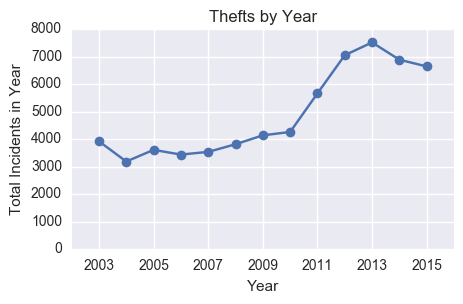

In [6]:
yearlytotal = df.year.value_counts().to_frame(name="count").sort_index()
yearlytotal['year'] = yearlytotal.index
plt.plot(yearlytotal['year'],yearlytotal['count'],'o-')
plt.xlabel('Year')
plt.ylabel('Total Incidents in Year')
plt.title(uppercase+' by Year')

if dataset == 'thefts':
    plt.axis([2002, 2016, 0, 8000])
elif dataset == 'robberies':
    plt.axis([2002, 2016, 0, 3000])
plt.xticks(range(2003,2016,2), range(2003,2016,2))
plt.tight_layout()
plt.savefig('plots/%s-yearlycounts.png' % lowercase)
pass

## Aggregated by month

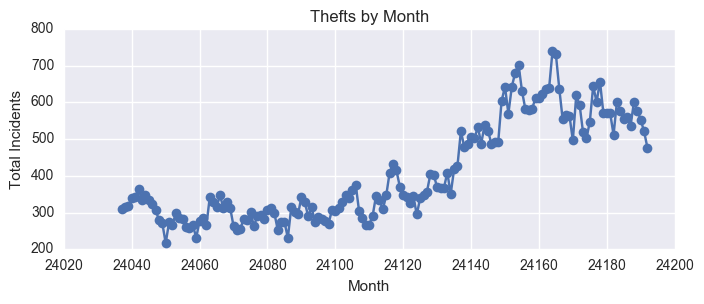

In [7]:
def monthyear2num(month,year):
    return year*12 + month

def num2monthyear(num):
    month = num % 12
    year = (num-month) / 12
    return "%.2d/%.2d" % (month,year)

groupbyyearmonth = df[['year','month']].groupby(by=['year','month']).size().to_frame(name="count")
groupbyyearmonth.reset_index(inplace=True)
groupbyyearmonth['monthyear'] = groupbyyearmonth.apply(lambda row: row['year']*12 + row['month'],axis=1)

plt.figure(figsize=(7.2,3.2))
plt.plot(groupbyyearmonth['monthyear'],groupbyyearmonth['count'],'o-')
plt.xlabel('Month')
plt.ylabel('Total Incidents')
plt.title(uppercase+' by Month')
plt.tight_layout()
pass

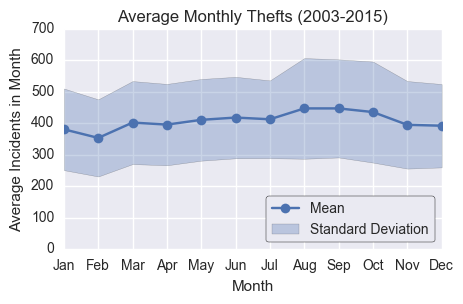

In [8]:
groupbymonth = groupbyyearmonth[['month','count']].groupby(by='month')
groupbymonth = groupbymonth['count'].agg({'sum' : sum, 'mean' : np.mean, 'std' : np.std})

plot_mean = plt.plot(groupbymonth.index,groupbymonth['mean'],'o-')
plot_std = plt.fill_between(groupbymonth.index, 
                 groupbymonth['mean']-groupbymonth['std'], 
                 groupbymonth['mean']+groupbymonth['std'],
                 alpha=.3)
plt.xlabel('Month')
plt.ylabel('Average Incidents in Month')
plt.title('Average Monthly %s (2003-2015)' % uppercase)
leg = plt.legend(['Mean','Standard Deviation'],loc='lower right')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([1, 12, 0, 700])
elif dataset == 'robberies':
    plt.axis([1, 12, 0, 250])

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
plt.tight_layout()
plt.savefig('plots/%s-monthlyaverage.png' % lowercase)
pass


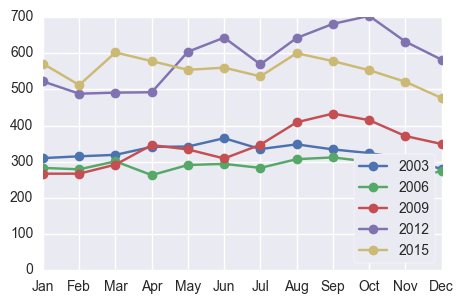

In [9]:
yearlist = [2003, 2006, 2009, 2012, 2015]
for year in yearlist:
    plt.plot(groupbyyearmonth[groupbyyearmonth.year==year]['month'],groupbyyearmonth[groupbyyearmonth.year==year]['count'],'o-')
plt.legend(yearlist,loc='lower right')
if dataset == 'thefts':
    plt.axis([1, 12, 0, 700])
elif dataset == 'robberies':
    plt.axis([1, 12, 0, 300])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
plt.tight_layout()
pass

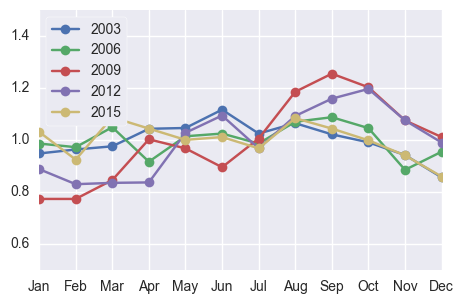

In [10]:
yearlist = [2003, 2006, 2009, 2012, 2015]
for year in yearlist:
    y = groupbyyearmonth[groupbyyearmonth.year==year]['count']/groupbyyearmonth[groupbyyearmonth.year==year]['count'].mean()
    plt.plot(groupbyyearmonth[groupbyyearmonth.year==year]['month'],y,'o-')
plt.legend(yearlist,loc='upper left')
plt.axis([1, 12, 0.5, 1.5])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
plt.tight_layout()
pass

## Daily counts over time

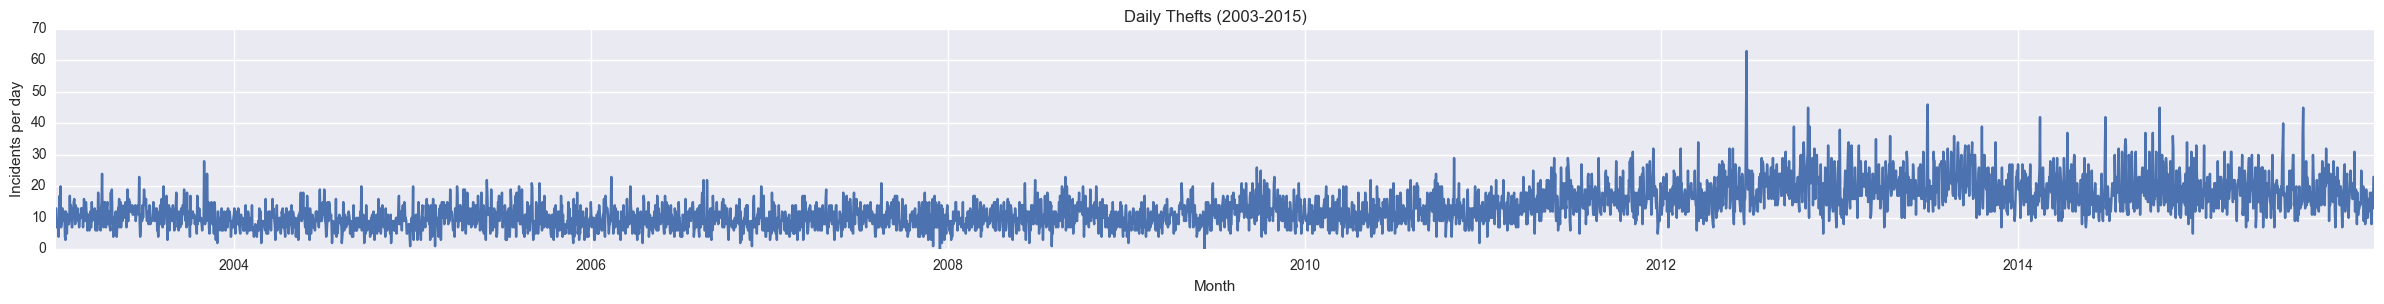

In [11]:
plt.figure(figsize=(4.8*5,3.2))
plt.plot(groupbydate['date'],groupbydate['count'],'-')
plt.xlabel('Month')
plt.ylabel('Incidents per day')
plt.title('Daily %s (2003-2015)' % uppercase)
plt.tight_layout()
pass

# Aggregated by time of day

In [12]:
def time2num(t):
    ts = t.hour * 60 + t.minute
    return ts

def scott_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 1.06*sigma*S.count()**(-0.2)

def silverman_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 0.9*sigma*S.count()**(-0.2)

class WrappedKDE:
    
    def __init__(self,S):
        # S is a pandas series
        self.bandwidth = silverman_bw(S)
        self.model = KernelDensity(bandwidth=self.bandwidth)
        return None
        
    def fit(self,data):
        self.model.fit(data.reshape(-1,1))
        return self
    
    def pdf(self,grid):
        grid = grid.reshape(-1,1)
        griddelta = grid[1]-grid[0]
        gridmax = grid[-1]+griddelta
        out = np.exp(self.model.score_samples(grid))
        out += np.exp(self.model.score_samples(grid-gridmax))
        out += np.exp(self.model.score_samples(grid+gridmax))
        return out

timekde = WrappedKDE(df.time.apply(time2num))
timekde.fit(df.time.apply(time2num))
print timekde.bandwidth
#timegrid = np.arange(1,1440,1)
#plt.scatter(timegrid, timekde.pdf(timegrid))
#plt.axis([0, 1440, 0, 0.002])

36.579132651


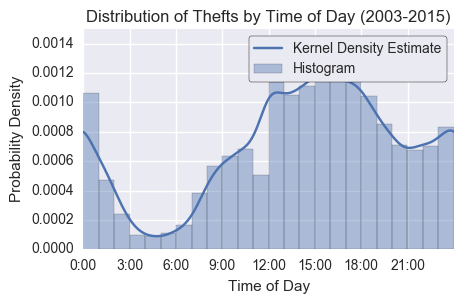

In [13]:
hours = ['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','24:00']
#plt.hist(df.time.apply(time2num),bins=24,normed=True,alpha=0.5)
sns.distplot(df.time.apply(time2num),kde = False,norm_hist=True,bins=24)

timegrid = np.arange(1,1440,1)
plt.plot(timegrid,timekde.pdf(timegrid),'-',color=sns.color_palette()[0])

plt.axis([0,1440,0,0.0015])
plt.xticks(range(0,1440,180), hours)

plt.xlabel('Time of Day')
plt.ylabel('Probability Density')
plt.title('Distribution of %s by Time of Day (2003-2015)' % uppercase)
if dataset == 'thefts':
    legloc = 'upper right'
elif dataset == 'robberies':
    legloc = 'lower right'
leg = plt.legend(['Kernel Density Estimate','Histogram'],loc=legloc)
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.tight_layout()
plt.savefig('plots/%s-timeofdaydistribution.png' % lowercase)
pass

# Aggregation by day of week

   dayofweekno  dayofweek       std      sum       mean  size    stderr
0            1     Monday  4.946297   7788.0  11.486726   678  0.189961
1            2    Tuesday  4.943504   8259.0  12.181416   678  0.189854
2            3  Wednesday  5.294609   8667.0  12.764359   679  0.203188
3            4   Thursday  5.592381   8920.0  13.136966   679  0.214616
4            5     Friday  6.657071  10422.0  15.371681   678  0.255663
5            6   Saturday  7.705901  10802.0  15.932153   678  0.295943
6            7     Sunday  7.186686   8814.0  13.000000   678  0.276003


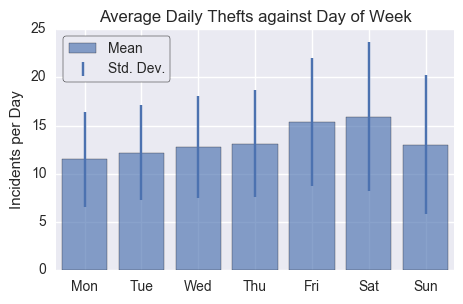

In [14]:
weekdayno ={ 
    u'Monday' : 1,
    u'Tuesday' : 2,
    u'Wednesday' : 3,
    u'Thursday' : 4,
    u'Friday' : 5,
    u'Saturday' : 6,
    u'Sunday' : 7
    }
groupbydate['dayofweekno'] = groupbydate['dayofweek'].apply(lambda x: weekdayno[x])

groupbyweekday = groupbydate.groupby(by=['dayofweekno','dayofweek'])
groupbyweekday = groupbyweekday['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbyweekday['stderr'] = groupbyweekday.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
groupbyweekday.reset_index(inplace=True)

print groupbyweekday

weekdaylabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

p = plt.bar(left=groupbyweekday['dayofweekno'].as_matrix(),
           height=groupbyweekday['mean'].as_matrix(),
           width=0.8,
           tick_label=weekdaylabels,
           align='center',
           yerr = groupbyweekday['std'],
           alpha=0.66)
if dataset == 'thefts':
    plt.axis([0.5,7.5,0,25])
elif dataset == 'robberies':
    plt.axis([0.5,7.5,0,11])
plt.title('Average Daily %s against Day of Week' % uppercase)
plt.ylabel('Incidents per Day')
leg = plt.legend([p,p.errorbar],['Mean','Std. Dev.'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.tight_layout()
plt.savefig('plots/%s-dayofweekaverage.png' % lowercase)
pass

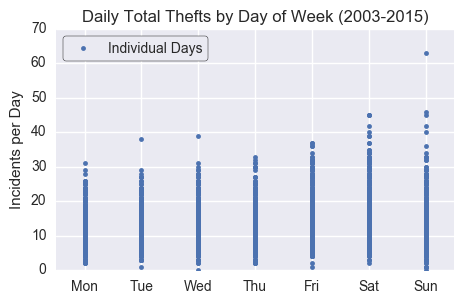

In [15]:
p = plt.plot(groupbydate['dayofweekno'],groupbydate['count'],'.')
if dataset == 'thefts':
    plt.axis([0.5,7.5,0,70])
elif dataset == 'robberies':
    pass

plt.title('Daily Total %s by Day of Week (2003-2015)' % uppercase)
plt.ylabel('Incidents per Day')
leg = plt.legend(['Individual Days'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.xticks(range(1,8,1), weekdaylabels)
plt.tight_layout()

pass

# Aggregation by spatial location

In [ ]:
# Fit spatial KDE

def silverman_bwxy(df):
    count = df['x'].count()
    stdx = df['x'].std()
    stdy = df['y'].std()
    iqrx = np.subtract(*np.percentile(df['x'], [75, 25]))
    iqry = np.subtract(*np.percentile(df['y'], [75, 25]))
    sigma = min(stdx,stdy,iqrx,iqry)
    return 0.9*sigma*count**(-0.2)

spacekde = KernelDensity(bandwidth = silverman_bwxy(df[['x','y']]),metric='haversine')
spacekde.fit(df[['x','y']])


In [ ]:
# Sample on a grid

xmin = -122.5237517
xmax = -122.3522017
ymin = 37.7040012
ymax = 37.8341382

xv, yv = np.meshgrid(np.arange(xmin,xmax,0.0004),np.arange(ymin,ymax,0.0004))
#xv, yv = np.meshgrid(np.linspace(xmin,xmax,num=400),np.linspace(ymin,ymax,num=100))

X_grid = np.vstack([xv.ravel(), yv.ravel()]).transpose()



Z = np.exp(spacekde.score_samples(X_grid))
Zv = Z.reshape(xv.shape)

levels = np.linspace(Zv.min(), Zv.max(), 25)
plt.contourf(xv, yv, Zv, levels=levels, cmap=plt.cm.Reds)
plt.title('Kernel Density Estimate of %s' % uppercase)
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.tight_layout()
plt.savefig('plots/%s-spatialkdeheatmap.png' % lowercase)

In [ ]:
# Save sampled data to file

Z_filt = Z/Z.max()

tol = 1e-4
Z_filt[abs(Z_filt) < tol] = 0.0

out = [[point[0], point[1], point[2]] for point in zip(X_grid[:,1],X_grid[:,0],Z_filt)]

with open("%s_kde.csv" % lowercase, "wb") as f:
    writer = csv.writer(f)
    writer.writerows(out)

# Weather

(4748, 4)


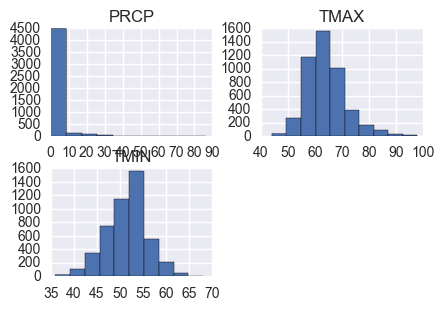

In [16]:
weather[weather.DATE < date(2016, 1, 1)].hist()
print weather[weather.DATE < date(2016, 1, 1)].shape
pass

## Aggregation by precipitation

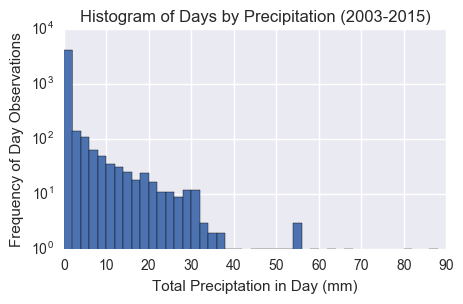

In [17]:
binsize = 2
binmin, binmax = 0, 90
plt.hist(groupbydate['PRCP'],normed=False,bins=range(0,binmax+1,binsize),log=True)

plt.xlabel('Total Preciptation in Day (mm)')
plt.ylabel('Frequency of Day Observations')
plt.title('Histogram of Days by Precipitation (2003-2015)')
plt.tight_layout()
plt.savefig('plots/precip_hist.png')

pass

               std      sum       mean  size    stderr
PRCP                                                  
[0, 2)    6.360267  56871.0  13.684071  4156  0.098659
[2, 4)    5.910434   1732.0  12.283688   141  0.497748
[4, 6)    6.362316   1334.0  12.127273   110  0.606623
[6, 8)    5.196645    715.0  11.349206    63  0.654716
[8, 10)   6.180945    610.0  12.200000    50  0.874118
[10, 12)  4.912246    374.0  10.388889    36  0.818708
[12, 14)  4.310777    337.0  10.870968    31  0.774238
[14, 16)  5.111425    268.0  10.720000    25  1.022285
[16, 18)  4.190325    159.0   8.833333    18  0.987669
[18, 20)  5.170814    265.0  11.041667    24  1.055488
[20, 22)  6.062784    177.0  10.411765    17  1.470441
[22, 24)  3.660601     99.0   9.000000    11  1.103713
[24, 26)  3.219260    123.0  11.181818    11  0.970643
[26, 28)  6.745369     93.0  10.333333     9  2.248456
[28, 30)  4.795042    137.0  11.416667    12  1.384209
[30, 32)  6.336522    158.0  13.166667    12  1.829196
[32, 34)  

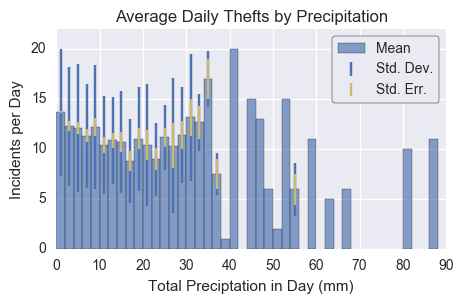

In [18]:
binsize = 2
binmin, binmax = 0, 90

groupbyprcp = groupbydate.groupby(pd.cut(groupbydate.PRCP,bins=range(0,binmax+1,binsize),right=False))
groupbyprcp = groupbyprcp['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbyprcp['stderr'] = groupbyprcp.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbyprcp

p = plt.bar(left=np.arange(binmin,binmax,binsize),
           height=groupbyprcp['mean'].as_matrix(),
           width=binsize,
           yerr = groupbyprcp['std'],
           alpha=0.66)

# Std Error
q = plt.errorbar(np.arange(binmin,binmax,binsize)+0.5*binsize, 
             groupbyprcp['mean'].as_matrix(), 
             yerr=groupbyprcp['stderr'].as_matrix(),
             fmt='none',
             ecolor=sns.color_palette()[4]
            )

plt.xlabel('Total Preciptation in Day (mm)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily %s by Precipitation' % uppercase)
leg = plt.legend([p,p.errorbar, q],['Mean','Std. Dev.','Std. Err.'],loc='upper right',frameon=True,fancybox=True)
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([binmin,binmax,0,22])
elif dataset == 'robberies':
    pass

plt.tight_layout()
plt.savefig('plots/%s-precipaverage.png' % lowercase)


0.0109127696076


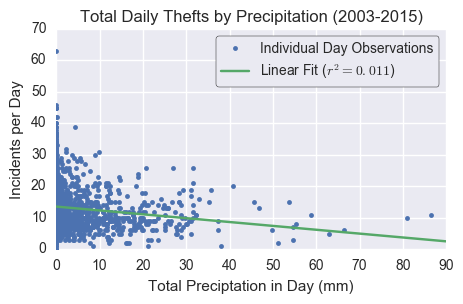

In [19]:
p = plt.plot(groupbydate['PRCP'],groupbydate['count'],'.')

# Fit linear regression
prcp_linreg = LinearRegression()
prcp_linreg.fit(groupbydate['PRCP'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
r2 = prcp_linreg.score(groupbydate['PRCP'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
print r2

# Plot linear regression
x = np.arange(0,91,1).reshape(-1,1)
plt.plot(x,prcp_linreg.predict(x))

plt.title('Total Daily %s by Precipitation (2003-2015)' % uppercase)
plt.xlabel('Total Preciptation in Day (mm)')
plt.ylabel('Incidents per Day')
leg = plt.legend(['Individual Day Observations','Linear Fit ($r^2 = %.3f$)' % r2],loc='upper right')
frame = leg.get_frame()
frame.set_edgecolor('black')

plt.tight_layout()
plt.savefig('plots/%s-preciplinfit.png' % lowercase)

pass

## Aggregation by TMAX

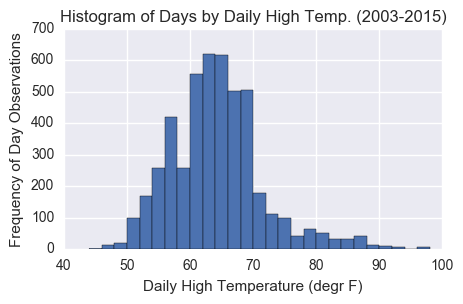

In [20]:
binsize = 2
binmin, binmax = 44, 98
plt.hist(groupbydate['TMAX'],normed=False,bins=range(binmin,binmax+1,binsize))

plt.xlabel('Daily High Temperature (degr F)')
plt.ylabel('Frequency of Day Observations')
plt.title('Histogram of Days by Daily High Temp. (2003-2015)')

plt.tight_layout()
plt.savefig('plots/tmax_hist.png')

pass

                std     sum       mean  size    stderr
TMAX                                                  
[44, 46)   6.244998    39.0  13.000000     3  3.605551
[46, 48)   5.535434   141.0  10.846154    13  1.535253
[48, 50)   6.597248   259.0  12.950000    20  1.475190
[50, 52)   5.707213  1163.0  11.514851   101  0.567889
[52, 54)   5.738781  1964.0  11.485380   171  0.438856
[54, 56)   5.423500  3113.0  12.019305   259  0.337000
[56, 58)   5.671391  5111.0  12.169048   420  0.276736
[58, 60)   5.993352  3413.0  13.228682   258  0.373130
[60, 62)   5.992121  7209.0  12.919355   558  0.253667
[62, 64)   6.486016  8582.0  13.797428   622  0.260066
[64, 66)   6.184184  8171.0  13.221683   618  0.248764
[66, 68)   6.389835  7068.0  14.051690   503  0.284909
[68, 70)   6.799610  7354.0  14.562376   505  0.302579
[70, 72)   6.747865  2865.0  16.005587   179  0.504359
[72, 74)   6.413260  1593.0  14.223214   112  0.605996
[74, 76)   7.253430  1454.0  14.836735    98  0.732707
[76, 78)  

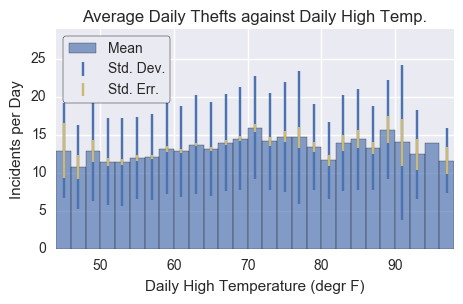

In [21]:
binsize = 2
binmin, binmax = 44, 98

#binsize = 5
#binmin, binmax = 40, 100

groupbytmax = groupbydate.groupby(pd.cut(groupbydate['TMAX'],bins=range(binmin,binmax+1,binsize),right=False))
groupbytmax = groupbytmax['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbytmax['stderr'] = groupbytmax.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbytmax


p = plt.bar(left=np.arange(binmin,binmax,binsize),
           height=groupbytmax['mean'].as_matrix(),
           width=binsize,
           yerr = groupbytmax['std'],
           alpha=0.66)

# Std Error
q = plt.errorbar(np.arange(binmin,binmax,binsize)+0.5*binsize, 
             groupbytmax['mean'].as_matrix(), 
             yerr=groupbytmax['stderr'].as_matrix(),
             fmt='none',
             ecolor=sns.color_palette()[4]
            )

plt.xlabel('Daily High Temperature (degr F)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily %s against Daily High Temp.' % uppercase)
leg = plt.legend([p,p.errorbar, q],['Mean','Std. Dev.', 'Std. Err.'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([binmin,binmax,0,29])
elif dataset == 'robberies':
    plt.axis([binmin,binmax,0,13])

plt.tight_layout()
plt.savefig('plots/%s-tmaxaverage.png' % lowercase)
pass

### Linear regression

-1.53556539637


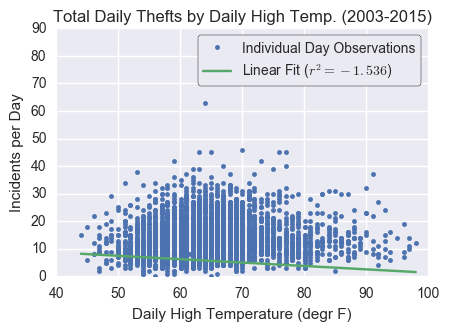

In [22]:
p = plt.plot(groupbydate['TMAX'],groupbydate['count'],'.')

# Fit linear regression
tmax_linreg = LinearRegression()
tmax_linreg.fit(groupbydate['TMAX'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
r2 = prcp_linreg.score(groupbydate['TMAX'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
print r2

# Plot linear regression
x = np.arange(44,99,1).reshape(-1,1)
plt.plot(x,prcp_linreg.predict(x))

plt.title('Total Daily %s by Daily High Temp. (2003-2015)' % uppercase)
plt.xlabel('Daily High Temperature (degr F)')
plt.ylabel('Incidents per Day')
leg = plt.legend(['Individual Day Observations','Linear Fit ($r^2 = %.3f$)' % r2],loc='upper right',frameon=True,fancybox=True)
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([40,100,0,90])
elif dataset == 'robberies':
    plt.axis([40,100,0,30])

pass

This is no good. $r^2 = -1.5$ which means fit is worse than horizontal line.

### Parabolic regression

{'ridge__alpha': 2.0}
-1.54247790616


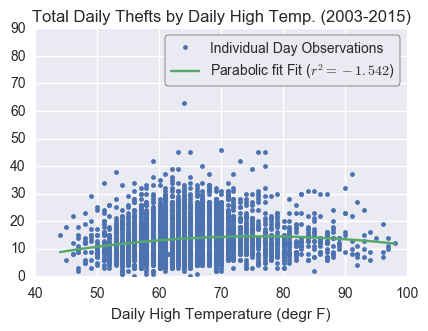

In [23]:
p = plt.plot(groupbydate['TMAX'],groupbydate['count'],'.')

# Fit polynomial regression
tmax_polypipe = Pipeline([
    ('polytrans',PolynomialFeatures(2)), 
    ('ridge',Ridge())
    ])
params = {'ridge__alpha' : np.linspace(0,2,20) }


cv = GridSearchCV(tmax_polypipe, param_grid=params)

x_dat = groupbydate['TMAX'].as_matrix().reshape(-1,1)
y_dat = groupbydate['count'].as_matrix().reshape(-1,1)
cv.fit(x_dat, y_dat)

print cv.best_params_
print cv.best_score_

x_plot = np.arange(44,99,1).reshape(-1,1)
y_plot = cv.predict(x_plot)

plt.plot(x_plot,y_plot)
plt.title('Total Daily %s by Daily High Temp. (2003-2015)' % uppercase)
plt.xlabel('Daily High Temperature (degr F)')
leg = plt.legend(['Individual Day Observations','Parabolic fit Fit ($r^2 = %.3f$)' % cv.best_score_],loc='upper right')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([40,100,0,90])
elif dataset == 'robberies':
    plt.axis([40,100,0,30])


This is no good. $r^2 = -1.5$ which means fit is worse than horizontal line.

## Aggregation by TMIN

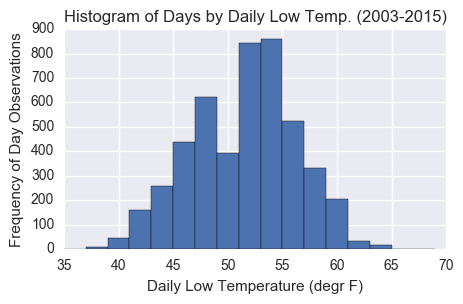

In [24]:
binsize = 2
binmin, binmax = 35, 69
plt.hist(groupbydate['TMIN'],normed=False,bins=range(binmin,binmax+1,binsize),log=False)

plt.xlabel('Daily Low Temperature (degr F)')
plt.ylabel('Frequency of Day Observations')
plt.title('Histogram of Days by Daily Low Temp. (2003-2015)')

plt.tight_layout()
plt.savefig('plots/tmin_hist.png')

pass

               std      sum       mean  size    stderr
TMIN                                                  
[35, 37)       NaN     12.0  12.000000     1       NaN
[37, 39)  5.592654     85.0   9.444444     9  1.864218
[39, 41)  4.760634    519.0  11.533333    45  0.709673
[41, 43)  5.873340   1942.0  12.062112   161  0.462884
[43, 45)  6.228138   3261.0  12.542308   260  0.386253
[45, 47)  5.582940   5338.0  12.215103   437  0.267068
[47, 49)  5.845798   8072.0  12.956661   623  0.234207
[49, 51)  6.114301   5118.0  13.022901   393  0.308426
[51, 53)  6.302365  11131.0  13.219715   842  0.217194
[53, 55)  6.219842  11733.0  13.674825   858  0.212342
[55, 57)  6.785458   7343.0  14.040153   523  0.296707
[57, 59)  6.418235   4752.0  14.356495   331  0.352778
[59, 61)  6.945721   3476.0  16.792271   207  0.482761
[61, 63)  9.056499    569.0  16.257143    35  1.530828
[63, 65)  8.103497    285.0  15.000000    19  1.859070
[65, 67)  1.527525     26.0   8.666667     3  0.881917
[67, 69)  

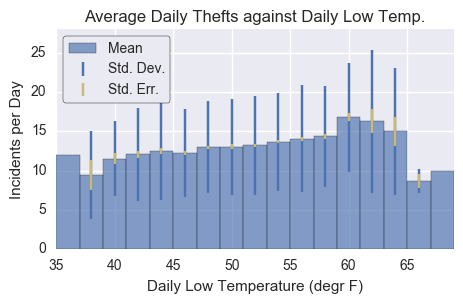

In [25]:
binsize = 2
binmin, binmax = 35, 69

#binsize = 5
#binmin, binmax = 35, 70

groupbytmin = groupbydate.groupby(pd.cut(groupbydate['TMIN'],bins=range(binmin,binmax+1,binsize),right=False))
groupbytmin = groupbytmin['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbytmin['stderr'] = groupbytmin.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbytmin

p = plt.bar(left=np.arange(binmin,binmax,binsize),
           height=groupbytmin['mean'].as_matrix(),
           width=binsize,
           yerr = groupbytmin['std'],
           alpha=0.66)

# Std Error
q = plt.errorbar(np.arange(binmin,binmax,binsize)+0.5*binsize, 
             groupbytmin['mean'].as_matrix(), 
             yerr=groupbytmin['stderr'].as_matrix(),
             fmt='none',
             ecolor=sns.color_palette()[4]
            )

plt.xlabel('Daily Low Temperature (degr F)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily %s against Daily Low Temp.' % uppercase)
leg = plt.legend([p,p.errorbar, q],['Mean','Std. Dev.', 'Std. Err.'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([binmin,binmax,0,28])
elif dataset == 'robberies':
    plt.axis([binmin,binmax,0,13])

plt.tight_layout()
plt.savefig('plots/%s-tminaverage.png' % lowercase)
pass